# SEC 10-K Filings Analysis

### This project aims to analyze the 10-K filings of a company (in this case, Microsoft) to extract insights related to revenue, debt, and management perspectives. Additionally, it calculates a risk score based on these factors for each year and visualizes the risk scores over time.

### Reason For choosing Risk score for Insight:

* ### Comprehensive Assessment: Provides a holistic evaluation of financial health and operational outlook.
* ### Quantitative Measurement: Offers a numerical value for easy comparison and trend analysis.
* ### Decision Support: Assists investors and company management in decision-making processes.


---



### Downloading necessary packages

In [4]:
!pip install sec-edgar-downloader

In [ ]:
!pip install -q -U google-generativeai

### Function to download 10-k filings of a company using Sec-edgar

In [ ]:

from sec_edgar_downloader import Downloader

def download_10k(ticker):
  """Downloads a 10-K filing for a company and year.

  Args:
      ticker: The company ticker symbol.
  """
  dl = Downloader("Sasefied", "singh.kirat.0409@gmail.com")
  filings = dl.get('10-K',ticker, download_details=False, after='1995-01-01', before='2023-12-31')
  print("<----------------------------Download completed----------------------------->")



In [ ]:
tickers=["MSFT","V"]
# ticker = input("Enter company ticker: ")
for ticker in tickers:
  download_10k(ticker)


<----------------------------Download completed----------------------------->
<----------------------------Download completed----------------------------->


### This function is to clean the 10-k filings... This was the most complex task! I tried html parser and Beautiful Soup  but still there was alot of noisy data (HTML TAGS/ SPECIAL CHARAVCTERS). But using this algorithm and Regex I got completely clean data.

In [3]:
import os
import re
from bs4 import BeautifulSoup


def auto_parse(html_content):
    cleaned_text = re.search(r'(?s)(?m)<TYPE>10-K.*?(</TEXT>)', html_content)
    if cleaned_text:
        cleaned_text = cleaned_text.group()
        cleaned_text = re.sub(r'((?i)<TYPE>).*?(?=<)', '', cleaned_text)
        cleaned_text = re.sub(r'((?i)<SEQUENCE>).*?(?=<)', '', cleaned_text)
        cleaned_text = re.sub(r'((?i)<FILENAME>).*?(?=<)', '', cleaned_text)
        cleaned_text = re.sub(r'((?i)<DESCRIPTION>).*?(?=<)', '', cleaned_text)
        cleaned_text = re.sub(r'(?s)(?i)<head>.*?</head>', '', cleaned_text)
        cleaned_text = re.sub(r'(?s)(?i)<(table).*?(</table>)', '', cleaned_text)
        cleaned_text = re.sub(r'(?s)(?i)(?m)> +Item|>Item|^Item', '>°Item', cleaned_text)
        cleaned_text = re.sub(r'(?s)<.*?>', ' ', cleaned_text)
        cleaned_text = re.sub(r'&(.{2,6});', ' ', cleaned_text)
        cleaned_text = re.sub(r'(?s) +', ' ', cleaned_text)
        return cleaned_text
    else:
        return None

def clean_document(file_path, output_directory):
    with open(file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()

    cleaned_text = auto_parse(html_content)
    if cleaned_text:
        parent_folder_name = os.path.basename(os.path.dirname(file_path))
        output_file_path = os.path.join(output_directory, f'cleaned_{parent_folder_name}.txt')
        with open(output_file_path, 'w', encoding='utf-8') as output_file:
            output_file.write(cleaned_text)
        print(f'Cleaned text saved to {output_file_path}')
    else:
        print(f'Error: No 10-K text found in {file_path}')

# Root directory containing all the folders
root_directory = 'sec-edgar-filings/MSFT'

# Specify the output directory for cleaned files
output_directory = 'cleaned_10k_files'
os.makedirs(output_directory, exist_ok=True)

# Loop through all folders and files in the root directory
for folder_name, subfolders, filenames in os.walk(root_directory):
    for filename in filenames:
        file_path = os.path.join(folder_name, filename)
        if os.path.isfile(file_path) and filename.endswith('.txt'):  # Ensure it's a text file
            clean_document(file_path, output_directory)


### This code is to check the total words in each file.
   Reason:- Due to limited context window of LLM via an API call... Generally 1500-1600 words words works well for 1 api call.

In [2]:
import os


# folder containing the 10-K filings
folder_path = 'cleaned_10k_files/'

# List to store file paths and their word counts
file_word_counts = []

#  Folders and files in the root directory
for folder_name, _, filenames in os.walk(folder_path):
    for filename in filenames:
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_name, filename)
            with open(file_path, 'r') as f:
                contents = f.read()
                words = contents.split()
                num_words = len(words)
                file_word_counts.append((file_path, num_words))

# Sort file_word_counts based on word counts
file_word_counts.sort(key=lambda x: x[1])

# Print file paths and their word counts in ascending order
for file_path, num_words in file_word_counts:
    print(f'{file_path}: Total words = {num_words}')


###  I have used Gemini as the LLM
Reason- It's free, comparitevely fast and generates good results.

In [ ]:

import google.generativeai as genai
GOOGLE_API_KEY=""

genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel('gemini-pro')

### Due to the context window limitation and the average file size of 20,000 words, it was not feasible to process the complete 10-K filing for a given year in a single pass. To address this challenge, the files were split into batches of 1,500 words each, and insights were generated for each batch. The insights from all batches were then saved in a single output file for a particular year, and this process was repeated for each year. Additionally, there was a limitation of making no more than 60 API calls per minute, necessitating a one-minute delay before making another set of 60 API calls.

### As the complete file was broken down into sections, there were inevitably many sections or batches that did not contain relevant insights. These sections were excluded because they followed a specific pattern. Finally, all the cleaned insights for each year were saved in the cleaned_output_files directory.

In [1]:

import os
import re
import time

# LLM Function to generate insights
def generate_responses(text):
    prompt = f"Act as an professional 10-k filings expert and your task is to extract important information and insights which could be very useful for a user. Focus on revenue, debt like revenue in given year, Debt in given year and management insights in short bullets point. AVOID HALUCINATION IF INFORMATION IS INCOMPLETE AND MAKE NO SENSE, IN THAT CASE AVOID GIVING INSIGHTS"

    try:
        # used this try block to capture such cases where api calls get blocked due to content restrictions. It usually happens with Gemini and LLM in general.
        results = model.generate_content(prompt + text)
        return results.text
    except ValueError as e:
        print(f"Error generating response: {e}")
        return None

def split_into_sections(text, words_per_section=1500):
    words = re.findall(r'\b\w+\b', text)  # Tokenize text into words
    sections = []
    for i in range(0, len(words), words_per_section):
        section_words = words[i:i+words_per_section]
        section_text = ' '.join(section_words)
        sections.append({"section_number": i // words_per_section + 1, "text": section_text})
    return sections
# directory containing the cleaned files
cleaned_directory = 'cleaned_10k_files/'


files = [file for file in os.listdir(cleaned_directory) if os.path.isfile(os.path.join(cleaned_directory, file))]


# Sort the files to ensure consistent order
files.sort()

# Initialize API call counter
api_calls = 0

# Define excluded phrases
exclude_phrases = ["i cannot provide", "Unable to provide insights", "I apologize", "i am unable to provide", "i apologise", "i regret", "i am sorry", "I'm sorry", "i cannot generate", "The context does not provide", "I cannot find the required", "I can't extract", " document does not contain"]

# Create output directory if it does not exist
output_directory = 'cleaned_output_files'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate through each file
for file_name in files:
    file_path = os.path.join(cleaned_directory, file_name)

    # Read the content of the file
    with open(file_path, 'r', encoding='utf-8') as file:
        data = file.read()

    # Split the document into smaller sections after every 1500 words
    sections = split_into_sections(data)

    # Generate insights for each section
    responses = []
    for section in sections:
        # Check if API call limit is reached
        if api_calls >= 60:
            print("API call limit reached. Waiting for 1 minute...")
            time.sleep(60)  # Wait for 1 minute
            api_calls = 0  # Reset API call counter

        response = generate_responses(section['text'])
        if response is not None:
            responses.append(response)
            api_calls += 1

    # Save the relevant responses to a text file
    relevant_responses = []
    for i, response in enumerate(responses):
        contains_exclude_phrase = any(phrase.lower() in response.lower() for phrase in exclude_phrases)
        if not contains_exclude_phrase:
            relevant_responses.append((i+1, response))

    output_file_path = os.path.join(output_directory, f"{file_name.split('.')[0]}_relevant_responses.txt")
    with open(output_file_path, 'w') as file:
        for section_num, response in relevant_responses:
            file.write(f"Section {section_num} Insights:\n")
            file.write(response)
            file.write("\n=========================\n")

    print(f"Relevant responses for {file_name} have been saved to '{output_file_path}'.")


### The insight data contained duplicates and was not in a format suitable for direct access and plotting. Therefore, a large language model (LLM) was utilized to convert the data into the desired format, and the transformed data was saved in a new directory.


In [ ]:

import os
import glob

def clean_responses(data):
    # Your existing function implementation here
    prompt = f'''The given content is very messy and duplicate data and have sections with no information.... your task is to only look for 3 things- revenue of that year(mention the year as well),
    Debt in that year and 3 Managemnet insight (overall) and you have to give it a risk score on the basis of all 3 factors so your output should look like-
    for Example-
    Revenue in 2000- $20 billion
    Debt in 2000- $ 1 bilion
    Management insight in 2000- 3 points
    Risk score in 2000- 10%

    This is just the format values will change according to the content provided.
    '''
    # Pass sentences together
    results= model.generate_content(prompt + data)
    return results.text

# Create result folder if not exists
if not os.path.exists('result_new'):
    os.makedirs('result_new')

# Loop through each file in the cleaned_output_files folder
for filename in glob.glob('cleaned_output_files/*.txt'):
    with open(filename, 'r') as f:
        data = f.read()

    # Process the data
    cleaned_data = clean_responses(data)

    # Get the filename without extension
    file_name_without_extension = os.path.splitext(os.path.basename(filename))[0]

    # Save the result in the result folder with the same filename
    result_file_path = os.path.join('result_new', f'{file_name_without_extension}_result.txt')
    with open(result_file_path, 'w') as f:
        f.write(cleaned_data)


### All the cleaned and well-formatted insight files were concatenated, and a function was employed to extract the risk score for each year using regular expressions. The extracted risk scores were then saved in a CSV file, which could be directly used for plotting.

In [ ]:
import csv
import re

# Read the concatenated file
concatenated_file_path = '/content/concatenated_output_all.txt'

with open(concatenated_file_path, 'r') as file:
    concatenated_content = file.read()

# Define the regular expression pattern to match risk scores
risk_score_pattern = r'Risk .*?(\d{4}).*?- ?(\d+/\d+|\d+%|\d+\.\d+%|\d+)'

# Find all risk scores in the concatenated content
risk_scores = re.findall(risk_score_pattern, concatenated_content)

# Specify the CSV file path
csv_file_path = '/content/risk_scores.csv'

# Write the extracted data to a CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    # Create a CSV writer object
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(['Year', 'Risk Score'])

    # Write the extracted year and risk score pairs
    for year, score in risk_scores:
        writer.writerow([year, score])

print("Data has been saved to:", csv_file_path)


Data has been saved to: /content/risk_scores.csv


### Finally, the risk scores were loaded, and a line graph was plotted to represent the risk percentage for each year by analyzing the management insights, revenue, debt, and sentiments.

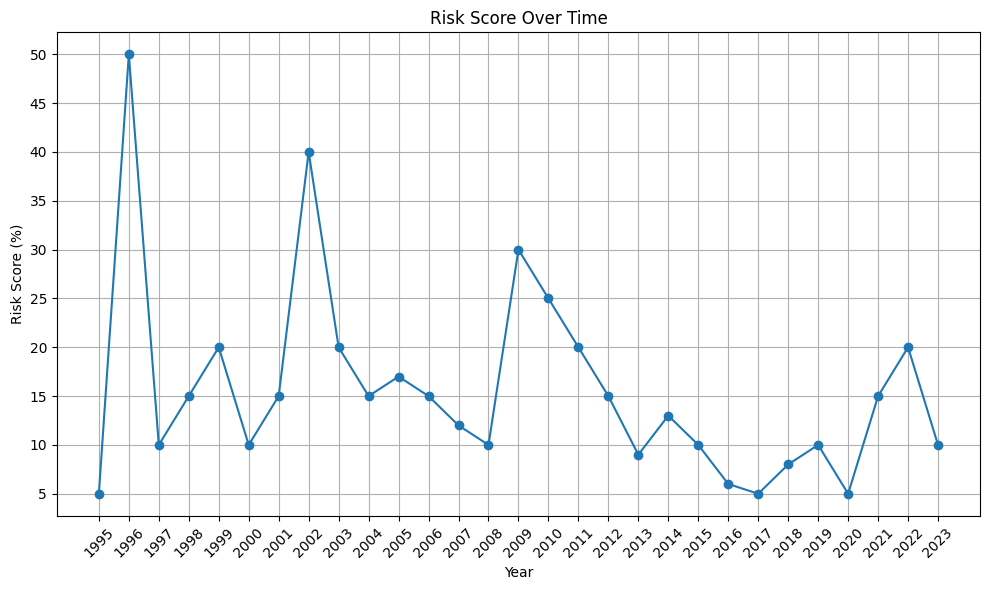

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('risk_scores.csv')


# Create the line graph
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Risk Score in %'], marker='o')
plt.xlabel('Year')
plt.ylabel('Risk Score (%)')
plt.title('Risk Score Over Time')

# Set y-axis ticks with equal intervals
min_score = df['Risk Score in %'].min()
max_score = df['Risk Score in %'].max()
tick_interval = 5  # Set the interval for y-axis ticks
plt.yticks(range(int(min_score), int(max_score) + tick_interval, tick_interval))

plt.xticks(df['Year'].unique(), rotation=45)  # Show all unique years on the x-axis, rotated for better visibility
plt.grid(True)
plt.tight_layout()
plt.show()


## My Analysis:

### The analysis reveals high-risk scores in 1996, 2002/03, and 2009, indicating specific financial challenges faced by the company during those years. The high-risk score in 1996 suggests a period of elevated debt levels. The risk scores in 2002 and 2003 align with the dotcom bubble burst, implying potential losses and a slowdown in growth during those years. Similarly, the high-risk score in 2009 corresponds to the 2008 economic breakdown, which likely led to a decline in revenue. The ability of the large language model (LLM) to capture and highlight these financial events through elevated risk scores demonstrates its effectiveness in generating meaningful insights from the 10-K filings.

## Challenges:


* The solution lacks cost-effectiveness, as it requires making k×N API calls for K files and N batches for each file, in addition to K API calls for formatting the output.
* Secondly, there were inconsistencies in the generated output from the large language model (LLM), making it even more difficult to automate the extraction of insights.
* This process is still time-consuming, and the chances of hallucination (generating inaccurate or irrelevant information) from the LLM are high.


## Possible Solutions:


*   One potential solution being considered is the implementation of a Retrieval-Augmented Generation (RAG) model to save costs, as it would eliminate the need for batch processing, thereby reducing the number of API calls required. Additionally, RAG could provide more specific information, reducing the likelihood of hallucination. However, since the 10-K filing data is unstructured, the retrieval performance would heavily depend on the query passed to the model. Therefore, a high-level mechanism needs to be devised, as RAG also has its limitations. Determining the top K results would also be a significant challenge.

* Time and latency remain significant concerns, as the vectorization of such a large document requires substantial time and memory. Consequently, alternative approaches need to be explored to handle these issues effectively.





PS: I really enjoy the Ideation, Implementation and Execution of this assignment. It is one of the most Interesting thing I have done recently! Thankyou so much for this opportunity.